In [ ]:
%matplotlib inline
import sys
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import random
import skimage
from keras import backend as K
from skimage.transform import resize,rotate

# import tensorflow.keras.backend as K
# import tensorflow as tf
# import re 

import xarray as xr
sys.path.append("../scripts")
from dea_plotting import map_shapefile
from dea_spatialtools import xr_rasterize
from dea_datahandling import load_ard
from datacube import Datacube
from utils import extract_name,clean_name,extract_id,clean_gdf,contain,get_date,get_coor,get_rgb,resize_cluster
from model import get_model
from metrics import dice_coef_loss,f1_m
from predict import get_results
from data_load import load_linescan_X,load_satellite_train,load_linescan_Y,load_satellite_test


In [ ]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

In [ ]:
dc = Datacube(app="Challenge1")

## Data Preperation
> 
Importing The Train/Test Data and proprocessing. Steps include sorting visualizing and understanding the data four further usage

```
df.info() : which is used to print a concise summary of the dataframe
df.head() : to print the first n rows of our dataframe
df.sort_values() : sorts a data frame in Ascending or Descending order of passed Column
df.apply() : apply a function along an axis of the dataframe
pd.to_datetime(df['col']**bold text**) : helps to convert string Date time into Python Date time object

lambda : 
*   Lambda functions are used when you need a function for a short period of time. 
*   This is commonly used when you want to pass a function as an argument to higher-order functions, that is, functions that take other functions as their arguments.

For further reading on lambda function visit https://www.w3schools.com/python/python_lambda.asp
```

In [ ]:
linescan_datasets = dc.find_datasets(product='linescan')
linescan_datasets = sorted(linescan_datasets, key = lambda ds: (ds.center_time, ds.id))

In [ ]:
type(linescan_datasets[0])

datacube.model.Dataset

In [ ]:
#Creating The Linescan_Df(organise The list linescan_datasets into pandas DataFrame )
linescan_df=pd.DataFrame(linescan_datasets,columns=['ds'])
linescan_df["label"]=linescan_df['ds'].apply(lambda ds:ds.metadata_doc["label"])
linescan_df=linescan_df.sort_values(by="label")

In [ ]:
linescan_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 23 to 125
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ds      134 non-null    object
 1   label   134 non-null    object
dtypes: object(2)
memory usage: 3.1+ KB


In [ ]:
#import The Train and test Data along the gdf file (polygons)
train = pd.read_csv('resources/challenge1_train.csv', index_col='id')
test = pd.read_csv('resources/challenge1_test.csv', index_col='id')
vector_file = 'resources/fire_boundaries.shp'
gdf = gpd.read_file(vector_file)

In [ ]:
train["name"]=train["label"].apply(lambda x:extract_name(x))

In [ ]:
train.head()

,label,dateTimeLocal,dateTimeUTC,name
id,,,,
0,ROSEDALE_P1_201901041439_MGA94_55,4/01/2019 14:39,4/01/2019 3:39,ROSEDALE
1,ROSEDALE_1_P1_201901041446_MGA94_55,4/01/2019 14:46,4/01/2019 3:46,ROSEDALE_1
2,ROSEDALE_3_P1_201901041501_MGA94_55,4/01/2019 15:01,4/01/2019 4:01,ROSEDALE_3
3,POINT_H_62_P1_201901162128_MGA94_55,16/01/2019 21:28,16/01/2019 10:28,POINT_H_62
4,NUNNETT_73_P1_201901171134_MGA94_55,17/01/2019 11:34,17/01/2019 0:34,NUNNETT_73


In [ ]:
train=train.sort_values(by="name")

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129 entries, 23 to 114
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   label          129 non-null    object
 1   dateTimeLocal  129 non-null    object
 2   dateTimeUTC    129 non-null    object
 3   name           129 non-null    object
dtypes: object(4)
memory usage: 5.0+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   label          5000 non-null   object 
 1   x              5000 non-null   int64  
 2   y              5000 non-null   int64  
 3   dateTimeLocal  5000 non-null   object 
 4   dateTimeUTC    5000 non-null   object 
 5   target         0 non-null      float64
dtypes: float64(1), int64(2), object(3)
memory usage: 273.4+ KB


In [ ]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 976 entries, 0 to 975
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Source      975 non-null    object  
 1   SourceName  975 non-null    object  
 2   Type        975 non-null    object  
 3   dtString    976 non-null    object  
 4   Comments    410 non-null    object  
 5   dtUTC       976 non-null    object  
 6   dtLocal     976 non-null    object  
 7   ID          976 non-null    int64   
 8   event       976 non-null    object  
 9   geometry    976 non-null    geometry
dtypes: geometry(1), int64(1), object(8)
memory usage: 76.4+ KB


In [ ]:
#getting the test labels used later to seperate The the Train and test from the linescan_df
test_labels=test.label.unique()

In [ ]:
#Seperating The train Data 
linescantrain_df=linescan_df[linescan_df["label"].apply(lambda x: x not in test_labels)]
linescantest_df=linescan_df[linescan_df["label"].apply(lambda x: x in test_labels)]

In [ ]:
#Seperating The composite polygones from The simple polygones
composites = gdf[gdf.SourceName.str.upper().str.contains(",|&|(COMPOSITE)", na=False)]

/env/lib/python3.6/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [ ]:
#Clean The labels in The gdf 
gdf['SourceNameClean'] = gdf.apply(lambda row: clean_name(row.SourceName), axis=1)

In [ ]:
#change The time from String ro dateTime objects
gdf["dtUTC"]=pd.to_datetime(composites['dtUTC'])
gdf["dtLocal"]=pd.to_datetime(composites['dtLocal'])

In [ ]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 976 entries, 0 to 975
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Source           975 non-null    object        
 1   SourceName       975 non-null    object        
 2   Type             975 non-null    object        
 3   dtString         976 non-null    object        
 4   Comments         410 non-null    object        
 5   dtUTC            285 non-null    datetime64[ns]
 6   dtLocal          285 non-null    datetime64[ns]
 7   ID               976 non-null    int64         
 8   event            976 non-null    object        
 9   geometry         976 non-null    geometry      
 10  SourceNameClean  975 non-null    object        
dtypes: datetime64[ns](2), geometry(1), int64(1), object(7)
memory usage: 84.0+ KB


In [ ]:
train["dateTimeUTC"]=pd.to_datetime(train['dateTimeUTC'])
train["dateTimeLocal"]=pd.to_datetime(train['dateTimeLocal'])

In [ ]:
composites.head()

,Source,SourceName,Type,dtString,Comments,dtUTC,dtLocal,ID,event,geometry
240,Linescan,"Composite wallhalla 397,398 & 401 20190225 (13...",Spot,2019/02/25 13:40:00.000,None,2019-02-25 02:40:00,2019-02-25 13:40:00,2051,Walhalla,"POLYGON ((453658.667 5803930.429, 453665.375 5..."
241,Linescan,"Composite wallhalla 397,398 & 401 20190225 (13...",Main run,2019/02/25 13:40:00.000,poor resolution on scan - fire very quiet - in...,2019-02-25 02:40:00,2019-02-25 13:40:00,2084,Walhalla,"POLYGON ((455929.360 5795742.381, 455923.878 5..."
242,Linescan,"Composite wallhalla 397,398 & 401 20190225 (13...",Spot,2019/02/25 13:40:00.000,None,2019-02-25 02:40:00,2019-02-25 13:40:00,2053,Walhalla,"POLYGON ((449321.816 5797497.661, 449310.878 5..."
315,Linescan,"macalister 681 & 682, (684 & 685 minor) compos...",Spot,2019/03/08 05:19:59.000,None,2019-03-07 18:19:59,2019-03-08 05:19:59,1151,Macalister91,"POLYGON ((488004.969 5843240.937, 488004.818 5..."
316,Linescan,"macalister 681 & 682, (684 & 685 minor) compos...",Spot,2019/03/08 05:19:59.000,None,2019-03-07 18:19:59,2019-03-08 05:19:59,1154,Macalister91,"POLYGON ((496572.570 5844159.446, 496563.396 5..."


In [ ]:
gdf.head()

,Source,SourceName,Type,dtString,Comments,dtUTC,dtLocal,ID,event,geometry,SourceNameClean
0,Linescan,aberfeldy west 200 p1_201901260955_mga94_55.jpg,Initial ignition,2019/01/26 09:55:00.000,originally Latrobe 87 - Jericho - Jim Track,NaT,NaT,0,Latrobe86,"POLYGON ((431455.605 5829806.837, 431460.570 5...",ABERFELDY_WEST_200_P1_201901260955_MGA94_55
1,Linescan,aberfeldy west 200 p1_201901260955_mga94_55.jpg,Initial ignition,2019/01/26 09:55:00.000,originally Latrobe 86 - Jericho - Thomson - Jo...,NaT,NaT,1,Latrobe86,"POLYGON ((433874.449 5827986.798, 433882.377 5...",ABERFELDY_WEST_200_P1_201901260955_MGA94_55
2,Linescan,aberfeldy west 200 p1_201901260955_mga94_55.jpg,Initial ignition,2019/01/26 09:55:00.000,originally Latrobe 85 - Jericho - Cream Can Hill,NaT,NaT,2,Latrobe86,"POLYGON ((430459.914 5831285.492, 430457.641 5...",ABERFELDY_WEST_200_P1_201901260955_MGA94_55
3,Linescan,aberfeldy west 214 p1_201901261750_mga94_55.jpg,Spot,2019/01/26 17:50:00.000,originally Latrobe 87 - Jericho - Jim Track,NaT,NaT,3,Latrobe86,"POLYGON ((431937.376 5829943.371, 431941.068 5...",ABERFELDY_WEST_214_P1_201901261750_MGA94_55
4,Linescan,aberfeldy west 214 p1_201901261750_mga94_55.jpg,Main run,2019/01/26 17:50:00.000,originally Latrobe 87 - Jericho - Jim Track,NaT,NaT,4,Latrobe86,"POLYGON ((431541.651 5829804.025, 431547.139 5...",ABERFELDY_WEST_214_P1_201901261750_MGA94_55


In [ ]:
#extract the id
train["id"]=train["label"].apply(lambda x:extract_id(x))

In [ ]:
gdf["SourceNameClean"]=gdf["SourceName"].apply(lambda x:clean_gdf(x))

In [ ]:
#extratct the ids from the mask (1 id per mask if simple mask ,else more if composite polygon)
gdf["ids"]=gdf["SourceNameClean"].apply(lambda x:extract_id(x))

In [ ]:
composites = gdf[gdf.SourceName.str.upper().str.contains(",|&|(COMPOSITE)", na=False)]

/env/lib/python3.6/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


## Demo scripts

In [ ]:
resolution = (-10, 10)
measurements = ['nbar_blue', 'nbar_green', 'nbar_red']
min_gooddata = 0.5
output_crs = 'epsg:28355'
products = ['ga_s2a_ard_nbar_granule', 'ga_s2b_ard_nbar_granule']

In [ ]:
# Demo of The get_rgb()
ds=linescantrain_df.ds.iloc[4]
start_date_post,end_date_post=get_date(ds)
study_area_lat,study_area_lon=get_coor(ds)
fire = load_ard(dc=dc,
                    products=products,
                    x=study_area_lon,
                    y=study_area_lat,
                    time=(start_date_post, end_date_post),
                    measurements=measurements,
                    min_gooddata=0.5,
                    output_crs=output_crs,
                    resolution=resolution,
               )
fire=fire.isel(time=0)
red=np.expand_dims(fire["nbar_red"].data,axis=-1)
green=np.expand_dims(fire["nbar_green"].data,axis=-1)
blue=np.expand_dims(fire["nbar_blue"].data,axis=-1)
rgb_img=np.concatenate((red,green,blue),axis=-1)
rgb_img_normal=resize(rgb_img,(IMG_HEIGHT,IMG_WIDTH))
rgb_img_standardized=get_rgb(fire)

Finding datasets
    ga_s2a_ard_nbar_granule
    ga_s2b_ard_nbar_granule
Counting good quality pixels for each time step
Filtering to 1 out of 5 time steps with at least 50.0% good quality pixels
Applying pixel quality/cloud mask
Loading 1 time steps


In [ ]:
print("Normal image pixels value range from {} to {}".format(rgb_img.min(),rgb_img.max()))
print("Standardized image pixels value range from {} to {}".format(rgb_img_standardized.min(),rgb_img_standardized.max()))

Normal image pixels value range from 10.0 to 3323.0
Standardized image pixels value range from 0.0 to 1.0


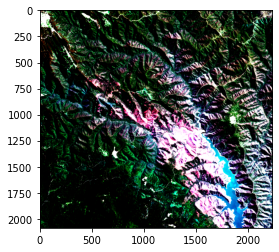

In [ ]:
plt.imshow(rgb_img_standardized)

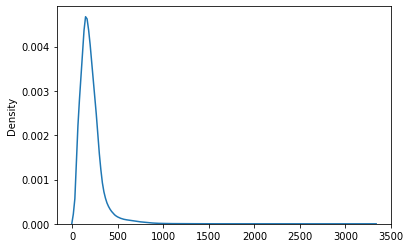

In [ ]:
sns.kdeplot(rgb_img.flatten())

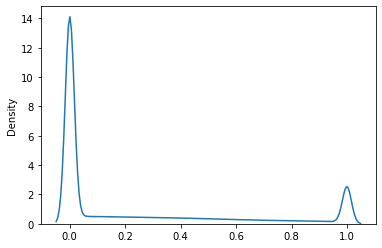

In [ ]:
sns.kdeplot(rgb_img_standardized[:,:,1].flatten())

## Loading data

In [ ]:
X_train=load_linescan_X(dc,linescantrain_df,IMG_HEIGHT,IMG_WIDTH)

In [ ]:
X_train_satellite=load_satellite_X(dc,linescantrain_df,products,measurements,output_crs,resolution,IMG_HEIGHT, IMG_WIDTH)

Finding datasets
    ga_s2a_ard_nbar_granule
    ga_s2b_ard_nbar_granule
Counting good quality pixels for each time step
Filtering to 1 out of 6 time steps with at least 50.0% good quality pixels
Applying pixel quality/cloud mask
Loading 1 time steps
Finding datasets
    ga_s2a_ard_nbar_granule
    ga_s2b_ard_nbar_granule
Counting good quality pixels for each time step
Filtering to 1 out of 6 time steps with at least 50.0% good quality pixels
Applying pixel quality/cloud mask
Loading 1 time steps
Finding datasets
    ga_s2a_ard_nbar_granule
    ga_s2b_ard_nbar_granule
Counting good quality pixels for each time step
Filtering to 1 out of 6 time steps with at least 50.0% good quality pixels
Applying pixel quality/cloud mask
Loading 1 time steps
Finding datasets
    ga_s2a_ard_nbar_granule
    ga_s2b_ard_nbar_granule
Counting good quality pixels for each time step
Filtering to 1 out of 6 time steps with at least 50.0% good quality pixels
Applying pixel quality/cloud mask
Loading 1 time st

Finding datasets
    ga_s2a_ard_nbar_granule
    ga_s2b_ard_nbar_granule
Counting good quality pixels for each time step
Filtering to 1 out of 5 time steps with at least 50.0% good quality pixels
Applying pixel quality/cloud mask
Loading 1 time steps
Finding datasets
    ga_s2a_ard_nbar_granule
    ga_s2b_ard_nbar_granule
Counting good quality pixels for each time step
Filtering to 1 out of 6 time steps with at least 50.0% good quality pixels
Applying pixel quality/cloud mask
Loading 1 time steps
Finding datasets
    ga_s2a_ard_nbar_granule
    ga_s2b_ard_nbar_granule
Counting good quality pixels for each time step
Filtering to 1 out of 6 time steps with at least 50.0% good quality pixels
Applying pixel quality/cloud mask
Loading 1 time steps
Finding datasets
    ga_s2a_ard_nbar_granule
    ga_s2b_ard_nbar_granule
Counting good quality pixels for each time step
Filtering to 1 out of 5 time steps with at least 50.0% good quality pixels
Applying pixel quality/cloud mask
Loading 1 time st

Finding datasets
    ga_s2a_ard_nbar_granule
    ga_s2b_ard_nbar_granule
Counting good quality pixels for each time step
Filtering to 0 out of 10 time steps with at least 50.0% good quality pixels
Applying pixel quality/cloud mask
Loading 0 time steps
Finding datasets
    ga_s2a_ard_nbar_granule
    ga_s2b_ard_nbar_granule
Counting good quality pixels for each time step
Filtering to 0 out of 11 time steps with at least 50.0% good quality pixels
Applying pixel quality/cloud mask
Loading 0 time steps
Finding datasets
    ga_s2a_ard_nbar_granule
    ga_s2b_ard_nbar_granule
Counting good quality pixels for each time step
Filtering to 1 out of 6 time steps with at least 50.0% good quality pixels
Applying pixel quality/cloud mask
Loading 1 time steps
Finding datasets
    ga_s2a_ard_nbar_granule
    ga_s2b_ard_nbar_granule
Counting good quality pixels for each time step
Filtering to 1 out of 6 time steps with at least 50.0% good quality pixels
Applying pixel quality/cloud mask
Loading 1 time 

Finding datasets
    ga_s2a_ard_nbar_granule
    ga_s2b_ard_nbar_granule
Counting good quality pixels for each time step
Filtering to 1 out of 6 time steps with at least 50.0% good quality pixels
Applying pixel quality/cloud mask
Loading 1 time steps
Finding datasets
    ga_s2a_ard_nbar_granule
    ga_s2b_ard_nbar_granule
Counting good quality pixels for each time step
Filtering to 1 out of 6 time steps with at least 50.0% good quality pixels
Applying pixel quality/cloud mask
Loading 1 time steps
Finding datasets
    ga_s2a_ard_nbar_granule
    ga_s2b_ard_nbar_granule
Counting good quality pixels for each time step
Filtering to 1 out of 5 time steps with at least 50.0% good quality pixels
Applying pixel quality/cloud mask
Loading 1 time steps
Finding datasets
    ga_s2a_ard_nbar_granule
    ga_s2b_ard_nbar_granule
Counting good quality pixels for each time step
Filtering to 2 out of 5 time steps with at least 50.0% good quality pixels
Applying pixel quality/cloud mask
Loading 2 time st

In [ ]:
y_train=load_linescan_Y(dc,train,linescantrain_df,gdf,IMG_HEIGHT,IMG_WIDTH)

Rasterizing to match xarray.DataArray dimensions (777, 1171)
Rasterizing to match xarray.DataArray dimensions (1297, 3333)
Rasterizing to match xarray.DataArray dimensions (1873, 2125)
Rasterizing to match xarray.DataArray dimensions (4800, 3381)
Rasterizing to match xarray.DataArray dimensions (2052, 2196)
Rasterizing to match xarray.DataArray dimensions (1280, 2513)


/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Rasterizing to match xarray.DataArray dimensions (2022, 2435)
Rasterizing to match xarray.DataArray dimensions (2295, 1799)
Rasterizing to match xarray.DataArray dimensions (3314, 1683)
Rasterizing to match xarray.DataArray dimensions (3860, 3393)
Rasterizing to match xarray.DataArray dimensions (3872, 3394)
Rasterizing to match xarray.DataArray dimensions (1963, 2224)
Rasterizing to match xarray.DataArray dimensions (4124, 3915)
Rasterizing to match xarray.DataArray dimensions (4614, 3084)
Rasterizing to match xarray.DataArray dimensions (3512, 2711)
Rasterizing to match xarray.DataArray dimensions (4447, 3094)
Rasterizing to match xarray.DataArray dimensions (3244, 3667)
Rasterizing to match xarray.DataArray dimensions (3693, 4477)
Rasterizing to match xarray.DataArray dimensions (2890, 3533)
Rasterizing to match xarray.DataArray dimensions (3661, 3966)
Rasterizing to match xarray.DataArray dimensions (3537, 3697)
Rasterizing to match xarray.DataArray dimensions (3427, 3662)
Rasteriz

In [ ]:
np.save("X_train_satellite_v3",X_train_satellite)
np.save("X_train_linescans",X_train)
np.save("y_train",y_train)

In [ ]:
found=open("found","r")
found=list(map(int,found.readline().split(",")[:-1]))
assigned=open("assigned","r")
assigned=list(map(int,assigned.readline().split(",")[:-1]))

In [ ]:
X_train_satellite=np.load("X_train_satellite_v3.npy")
X_train=np.load("X_train_linescans.npy")
y_train=np.load("y_train.npy")

## Handcrafted clustering based on visual similarities

In [ ]:
#chosed carefully based on visual simalrities
cluster1_X=X_train_satellite[[0,1,2,4,6,7,8,121,123,124,125,126,127]]
cluster1_y=y_train[[0,1,2,4,6,7,8,121,123,124,125,126,127]]

cluster2_X=X_train_satellite[[32,33,34,35,36,37,38,39,40,41,42,43,44]]
cluster2_y=y_train[[18,19,20,21,22,23,24,25,26,27,28,29,30,31,32]]

cluster3_X=X_train_satellite[[113,115,116,117,120]]
cluster3_y=y_train[[113,115,116,117,120]]



Xs=[cluster1_X,cluster2_X,cluster3_X]
Ys=[cluster1_y,cluster2_y,cluster3_y]

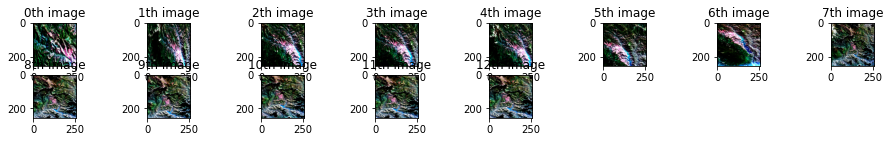

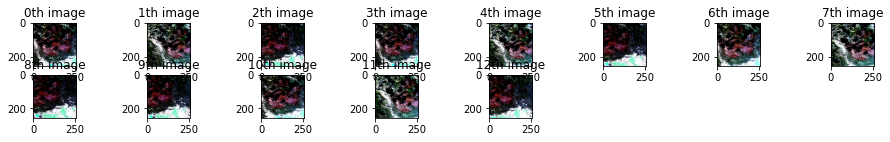

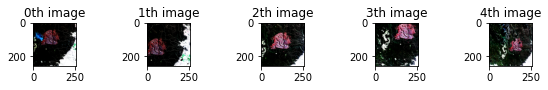

In [ ]:
for X in Xs:
    fig=plt.figure(figsize=(16, 16))
    columns = 8
    rows = 17
    for i in range(len(X)):
        img = X[i]
        fig.add_subplot(rows, columns, i+1)
        plt.title(f'{i}th image')
        plt.imshow(img)
#     plt.subplots_adjust(wspace=None, hspace=None)
    plt.show()

## Inference, Testing & Submission

In [ ]:
# import tensorflow as tf
model1=get_model(3, dice_coef_loss, [f1_m])
model2=get_model(3, dice_coef_loss, [f1_m])
model3=get_model(3, dice_coef_loss, [f1_m])
models=[model1,model2,model3]

In [ ]:
X_test,shapes,coords=load_satellite_test(dc,test_labels,linescantest_df,products,measurements,output_crs,resolution,IMG_HEIGHT, IMG_WIDTH)

Finding datasets
    ga_s2a_ard_nbar_granule
    ga_s2b_ard_nbar_granule
Counting good quality pixels for each time step
Filtering to 2 out of 6 time steps with at least 50.0% good quality pixels
Applying pixel quality/cloud mask
Loading 2 time steps
Finding datasets
    ga_s2a_ard_nbar_granule
    ga_s2b_ard_nbar_granule
Counting good quality pixels for each time step
Filtering to 2 out of 5 time steps with at least 50.0% good quality pixels
Applying pixel quality/cloud mask
Loading 2 time steps
Finding datasets
    ga_s2a_ard_nbar_granule
    ga_s2b_ard_nbar_granule
Counting good quality pixels for each time step
Filtering to 1 out of 5 time steps with at least 50.0% good quality pixels
Applying pixel quality/cloud mask
Loading 1 time steps
Finding datasets
    ga_s2a_ard_nbar_granule
    ga_s2b_ard_nbar_granule
Counting good quality pixels for each time step
Filtering to 2 out of 5 time steps with at least 50.0% good quality pixels
Applying pixel quality/cloud mask
Loading 2 time st

In [ ]:
test= get_results(models, linescantest_df, X_test,shapes,coords,test)

In [ ]:
test.to_csv('my_submission21.csv', columns = ['target'])

In [ ]:
test.target.value_counts()

0.0    2971
1.0    2029
Name: target, dtype: int64